In [1]:
import os
import sys
from pathlib import Path

import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io, metrics
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange
import cv2
import seaborn as sns

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"
match_info_dir = data_dir / "match"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils
import transform 

In [4]:
experiment = "Lung"
cores = ["B5", 'C6', 'D4', 'E4', 'E6', 'F4', 'F7']
datasets = ["_1", "_2", "_3","_4"]

# Get images

In [5]:
from typing import List
from skimage import measure
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from functools import partial
import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries
from skimage.transform import rotate
from skimage.filters import threshold_otsu
import matplotlib.offsetbox
from matplotlib.lines import Line2D

h5_data_dir = p_dir / "data" / "h5"

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={}, textprops={}, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False, textprops=textprops)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels


def contrast_stretching(img, n_min=30, n_max=100):
    # Contrast stretching
    p2, p98 = np.percentile(img, (n_min, n_max))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale

def crop_img(img, info):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = info["rotation_init"]
    rotation_small = info["rotation_adjust"]
    border = info["border"]

    img = rotate(img, rotation, resize=True)
    img = cv2.copyMakeBorder(
        img, border, border, border, border, cv2.BORDER_CONSTANT, None, value=0
    )
        
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]
        img = rotate(img, rotation_small, resize=True)
        
    if "affine" in info.keys():
        aff = info["affine"]
        pad = info["pad"]
        y = y - pad
        h_region = h_region + 2*pad
        x = x - pad
        w_region = w_region + 2*pad
        y = 0 if y < 0 else y
        x = 0 if x < 0 else x
        img_aff = img[y : y + h_region, x : x + w_region]
        img = transform.apply_global_affine(img_aff, img_aff, aff)
        y, h_region, x, w_region = info["bbox_aff"]
        
    img = img[y : y + h_region, x : x + w_region]
    img = contrast_stretching(img)
    img = img_as_ubyte(img)
    return img

def crop_img2(img, info):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = info["rotation_init"]
    rotation_small = info["rotation_adjust"]
    border = info["border"]

    img = rotate(img, rotation, resize=True)
    img = cv2.copyMakeBorder(
        img, border, border, border, border, cv2.BORDER_CONSTANT, None, value=0
    )
        
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]
        img = rotate(img, rotation_small, resize=True)
        
    img = img[y : y + h_region, x : x + w_region]
    img = contrast_stretching(img)
    img = img_as_ubyte(img)
    return img

def crop_img3(img, info):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = 0
    rotation_small = 0
    border = info["border"]

    img = rotate(img, rotation, resize=True)
    img = cv2.copyMakeBorder(
        img, border, border, border, border, cv2.BORDER_CONSTANT, None, value=0
    )
        
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]
        img = rotate(img, rotation_small, resize=True)
        
    img = img[200 : 200+h_region, 200 : 200+w_region]
    img = contrast_stretching(img)
    img = img_as_ubyte(img)
    return img

def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

# Read mask image
def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs, labels


def get_imgs_index(imgs, index_list, fov_dim):

    imgs_subset = imgs[index_list, :, :]
    img_combined = np.sum(imgs_subset, axis=0)
    img_downscale = resize(img_combined, (fov_dim, fov_dim), anti_aliasing=False)
    return img_downscale

In [6]:
subset = ["HistoneH3"]
struc_similarity1 = []
struc_similarity2 = []
struc_similarity3 = []

h_distance1 = []
h_distance2 = []
h_distance3 = []

for c in cores:
    print(f"Working on {c}")
    for d in datasets:
        dataset = c+d
        imgs_imc, markers = get_imgs(f"{experiment} {c}", "IMC")
        
        try:
            info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
        except:
            continue

        # ---- Load IMC image
        imgs_imc_stack = np.stack(imgs_imc)
        img_dapi = np.sum(imgs_imc_stack[[markers.index(marker) for marker in subset]], axis=0)
        img_dapi = contrast_stretching(img_dapi, n_min=2, n_max=95)
        img1 = crop_img(img_dapi, info) # with rotation and affine
        img2 = crop_img2(img_dapi, info) # Only rotation
        img3 = crop_img3(img_dapi, info)
        

        # ---- Load SIMS images
        imgs, labels = get_imgs_sims(experiment, dataset)
        # Read nulcie channel
        img_nuclei_downscale = get_imgs_index(imgs, [18, 32], fov_dim=img1.shape[0])
        # Contrast streching
        p2, p98 = np.percentile(img_nuclei_downscale, (10, 99.9))
        img_nuclei_downscale = exposure.rescale_intensity(
            img_nuclei_downscale, in_range=(p2, p98), out_range=(0, 255)
        )
        img_nuclei_downscale = img_nuclei_downscale.astype(np.uint8)
    
        struc_similarity1.append(metrics.structural_similarity(img1, img_nuclei_downscale))
        struc_similarity2.append(metrics.structural_similarity(img2, img_nuclei_downscale))
        struc_similarity3.append(metrics.structural_similarity(img3, img_nuclei_downscale))
        h_distance1.append(metrics.normalized_root_mse(img1, img_nuclei_downscale))
        h_distance2.append(metrics.normalized_root_mse(img2, img_nuclei_downscale))
        h_distance3.append(metrics.normalized_root_mse(img3, img_nuclei_downscale))
        
#         fig, ax = plt.subplots(figsize=(7,7))
#         ax.imshow(img1, cmap='gray')
#         ax.axis('off')
#         fig, ax = plt.subplots(figsize=(7,7))
#         ax.imshow(img2, cmap='gray')
#         ax.axis('off')
#         fig, ax = plt.subplots(figsize=(7,7))
#         ax.imshow(img3, cmap='gray')
#         ax.axis('off')
#         fig, ax = plt.subplots(figsize=(7,7))
#         ax.imshow(img_nuclei_downscale, cmap='hot')
#         ax.axis('off')

Working on B5
Working on C6
Working on D4
Working on E4
Working on E6
Working on F4
Working on F7


In [7]:
from statannotations.Annotator import Annotator


In [8]:
df = pd.DataFrame({'Affine': struc_similarity1, 'Rotation': struc_similarity2, 'Random': struc_similarity3})
df = df.melt(var_name='Registration Type', value_name='Structure Similarity')

In [13]:
df.to_clipboard()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Affine vs. Rotation: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.458e-04 U_stat=4.755e+02
Rotation vs. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.514e-08 U_stat=5.720e+02
Affine vs. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.191e-09 U_stat=5.760e+02


(array([0, 1, 2]),
 [Text(0, 0, 'Affine'), Text(1, 0, 'Rotation'), Text(2, 0, 'Random')])

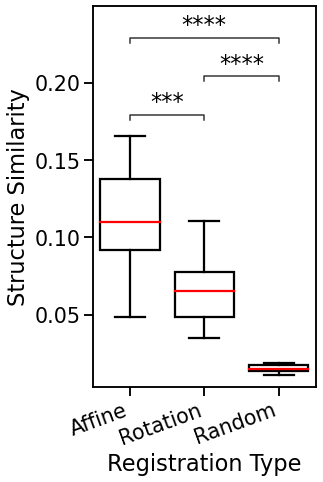

In [9]:
sns.set_context("talk", font_scale=1.25)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'r'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

fig, ax = plt.subplots(figsize=(4,7))
sns.boxplot(data=df, x='Registration Type', y='Structure Similarity', ax=ax, showfliers=False,**PROPS)

pairs=[("Affine", "Rotation"), ("Affine", "Random"), ("Rotation", "Random")]

annotator = Annotator(ax, pairs, data=df, x='Registration Type', y='Structure Similarity')
annotator.configure(test='Mann-Whitney', comparisons_correction="Bonferroni", text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.xticks(rotation = 20, ha='right')

In [10]:
df = pd.DataFrame({'Affine': h_distance1, 'Rotation': h_distance2, 'Random': h_distance3})
df = df.melt(var_name='Registration Type', value_name='Normalized Root Mean Square Error')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Affine vs. Rotation: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.168e-03 U_stat=1.355e+02
Rotation vs. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.423e-06 U_stat=5.400e+01
Affine vs. Random: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.171e-07 U_stat=2.100e+01


(array([0, 1, 2]),
 [Text(0, 0, 'Affine'), Text(1, 0, 'Rotation'), Text(2, 0, 'Random')])

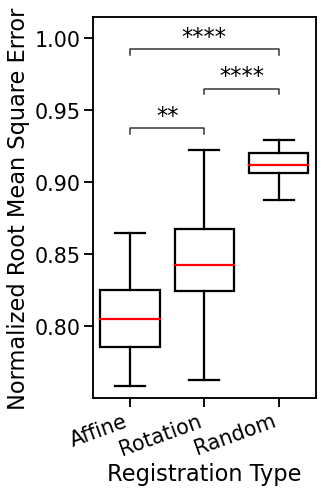

In [11]:
sns.set_context("talk", font_scale=1.25)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'r'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}

fig, ax = plt.subplots(figsize=(4,7))
sns.boxplot(data=df, x='Registration Type', y='Normalized Root Mean Square Error', ax=ax, showfliers=False,**PROPS)

pairs=[("Affine", "Rotation"), ("Affine", "Random"), ("Rotation", "Random")]

annotator = Annotator(ax, pairs, data=df, x='Registration Type', y='Normalized Root Mean Square Error')
annotator.configure(test='Mann-Whitney', comparisons_correction="Bonferroni", text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.xticks(rotation = 20, ha='right')